In [1]:
# importing esssential libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Importing tables..
campaign_desc=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\campaign_desc.csv")
campaign_table=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\campaign_table.csv")
causal_data=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\causal_data.csv")
coupon=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\coupon.csv")
coupon_redempt=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\coupon_redempt.csv")
hh_demographic=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\hh_demographic.csv")
product=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\product.csv")
transaction_data=pd.read_csv(r"C:\Users\HP\Downloads\G6 - Confidential\transaction_data.csv")
t=['campaign_desc','campaign_table','causal_data','coupon','coupon_redempt','hh_demographic','product','transaction_data']

# Target Generation
* As there are about 92k products out of which 44k are those products for which coupons were provided.
* Rest 48k are those products for which coupons were not provided.
* As we are clueless that how the manufacturer selected the products for which they had to provide coupons.
* To build a problem statement here we assume that manufacture has randomly selected the products for coupon generation.
* Our motive is to figureout the dependancy of coupon redemption on the product and on its historical data thus provided.
* Now all those products which were randomly selected for the coupon redemption. => will be consider as the training set
* All those products for which coupons were not provided previously => will turn out into real test set.

In [4]:
# tables formed throughout.
tables=pd.DataFrame({'Table names':['product','d','df1','df2'],'Description':['Product table with target variable',
                                                                            'Main table after feature engineering',
                                                                            'Tgt encoding is done on  Main table',
                                                                            'pd.factorize is done on Main table']})
tables

,Table names,Description
0,product,Product table with target variable
1,d,Main table after feature engineering
2,df1,Tgt encoding is done on Main table
3,df2,pd.factorize is done on Main table


In [5]:
# Triming the transaction_data table.
transaction_data=transaction_data[(transaction_data.QUANTITY!=0)&(transaction_data.SALES_VALUE!=0)]

In [6]:
product.PRODUCT_ID.nunique()  
# 92k products are available in total.

92353

In [7]:
coupon.PRODUCT_ID.nunique()   
# 44k are those products for which coupons were provided out of 92k.

44133

In [8]:
# creating the list containing the products for which coupon was provided.
productsforwhichcouponwasprovided=list(coupon.PRODUCT_ID.unique())
len(productsforwhichcouponwasprovided)

44133

In [9]:
product.PRODUCT_ID.nunique()-coupon.PRODUCT_ID.nunique()     
# 48k are those products for which coupons were not provided according to coupon table.

48220

In [10]:
transaction_data[(transaction_data.SALES_VALUE>0)&(transaction_data.QUANTITY>0)&(transaction_data.COUPON_DISC<0)]['PRODUCT_ID'].nunique()
# 9.2k are those products for which coupon was redempt.

9226

In [11]:
# creating the list containing the products for which coupon was redempt.
productsforwhichcouponwasredempt=list(transaction_data.loc[(transaction_data.SALES_VALUE>0)&(transaction_data.QUANTITY>0)&(transaction_data.COUPON_DISC<0),'PRODUCT_ID'].unique())
len(productsforwhichcouponwasredempt)

9226

In [12]:
# creation of the target variable..
p1 = product[product.PRODUCT_ID.isin(productsforwhichcouponwasprovided)]
p1['Target'] = p1.PRODUCT_ID.isin(productsforwhichcouponwasredempt).astype('int')
product['Target'] = p1['Target']
del p1

In [13]:
# function for creating target variable..
def yo(x):
    if (x in productsforwhichcouponwasprovided)&(x not in productsforwhichcouponwasredempt):
        return 0
    if (x in productsforwhichcouponwasprovided)&(x in productsforwhichcouponwasredempt):
        return 1
    if (x not in productsforwhichcouponwasprovided):
        return np.nan
#product['Target']=product.PRODUCT_ID.apply(yo)

In [21]:
product.Target.fillna(-1).value_counts()

-1.0    48220
 0.0    37995
 1.0     6138
Name: Target, dtype: int64

In [22]:
# checking for null values.
product.isnull().sum()
# The null values contained by Target are the actual test set on which we will do the final testing of our mode. 

PRODUCT_ID                  0
MANUFACTURER                0
DEPARTMENT                  0
BRAND                       0
COMMODITY_DESC              0
SUB_COMMODITY_DESC          0
CURR_SIZE_OF_PRODUCT        0
Target                  48220
dtype: int64

In [23]:
# MANUFACTURER is numercial columns with categorical properties. => before encoding and scaling to dtype to be changed.
product['MANUFACTURER']=product['MANUFACTURER'].astype('object')

In [24]:
d=product.copy()
d.set_index('PRODUCT_ID',inplace=True)
d.head(2)

,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Target
PRODUCT_ID,,,,,,,
25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0
26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN


In [25]:
catcol=d.select_dtypes('object').columns
numcol=d.select_dtypes(np.number).columns

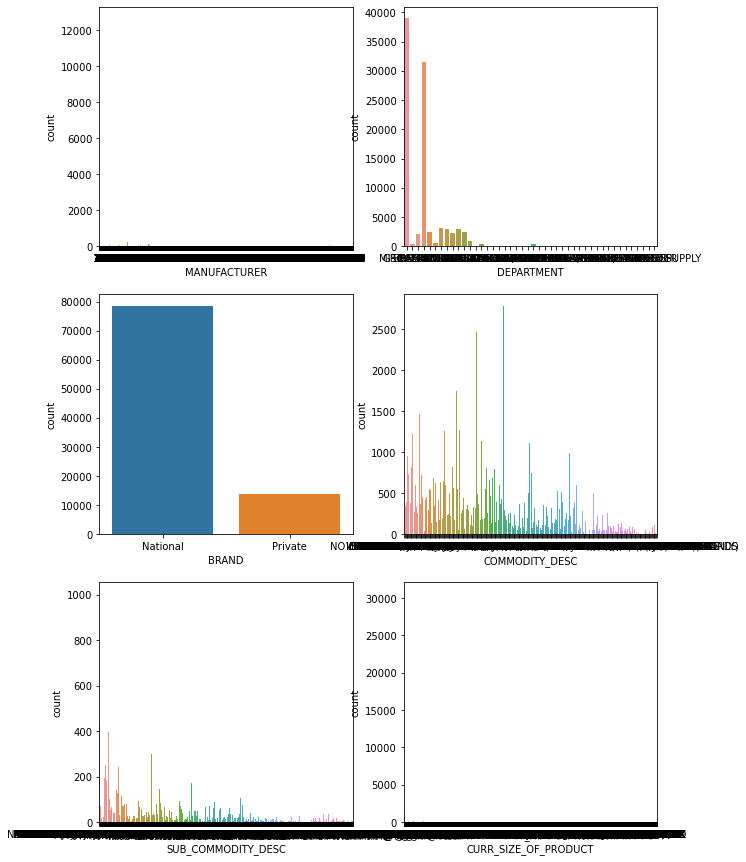

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(10,15))
t=1
for i in catcol:
    plt.subplot(3,2,t)
    sns.countplot(d[i])
    t=t+1
plt.show()
plt.tight_layout()

In [33]:
d['quantity_sold_total']=transaction_data.groupby('PRODUCT_ID')['QUANTITY'].sum()

<AxesSubplot:xlabel='Target', ylabel='quantity_sold_total'>

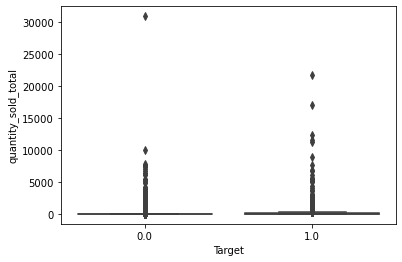

In [34]:
sns.boxplot(d['Target'],d['quantity_sold_total'])

In [35]:
# Feature Engineering..
# unique count of households that has purchased that particular product over the span of 2 years.
d['num_hsld_prch_prd']=transaction_data.groupby('PRODUCT_ID')['household_key'].nunique()

# unique count of stores that sells that particlar products.
d['num_stores_has_prd']=transaction_data.groupby('PRODUCT_ID')['STORE_ID'].nunique()

# count of products sold during the span of 2 years.
d['quantity_sold_total']=transaction_data.groupby('PRODUCT_ID')['QUANTITY'].sum()

In [36]:
d.isnull().sum()

MANUFACTURER                0
DEPARTMENT                  0
BRAND                       0
COMMODITY_DESC              0
SUB_COMMODITY_DESC          0
CURR_SIZE_OF_PRODUCT        0
Target                  48220
quantity_sold_total       448
num_hsld_prch_prd         448
num_stores_has_prd        448
dtype: int64

In [37]:
product.PRODUCT_ID.nunique()-transaction_data.PRODUCT_ID.nunique()
# Some products were never purchased.. => to be removed.

448

In [38]:
# triming those unpurchased products.
d=d.loc[sorted(transaction_data.PRODUCT_ID.unique())]

# Statistics

In [39]:
# statistical approval for categorical columns.
for i in d.select_dtypes('object').columns:
    tbl=pd.crosstab(d[i],d.Target)
    # Ho: has no effect, Target variable is independent of the respected column.
    # Ha: has an effect, Target variable is dependant on the respected column.
    ts,p,_,_=stats.chi2_contingency(tbl)
    print(i,':',p)

MANUFACTURER : 0.0
DEPARTMENT : 0.0
BRAND : 4.249617475100515e-168
COMMODITY_DESC : 0.0
SUB_COMMODITY_DESC : 0.0
CURR_SIZE_OF_PRODUCT : 5.7140933727928e-281


In [40]:
# statistical approval for numerical columns.
for i in d.select_dtypes(np.number).columns[1:]:
    zero=d.loc[d.Target==0,i]
    ones=d.loc[d.Target==1,i]
    # Ho: Data is normal
    # Ha: Data not normal
    p1=stats.shapiro(zero)[1]
    p2=stats.shapiro(ones)[1]
    if (p1<0.05)&(p2<0.05):
        # Ho: (has no effect) => Target variable is independent of the respected column.
        # Ha: (has an effect) => Target variable is dependant on the respected column.
        print(i,':',stats.mannwhitneyu(zero,ones)[1])
    else:
        # Ho: (has no effect) => Target variable is independent of the respected column.
        # Ha: (has an effect) => Target variable is dependant on the respected column.
        print(i,':',stats.ttest_ind(zero,ones)[1])

quantity_sold_total : 0.0
num_hsld_prch_prd : 0.0
num_stores_has_prd : 0.0


#  Encoding ~ trail 1 => Target Encoding

In [41]:
df1=d.copy()
from category_encoders import TargetEncoder
te=TargetEncoder()
for i in df1.select_dtypes('object').columns:
    df1[i]=te.fit_transform(df1[i],df1.Target)

In [42]:
df1 

,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Target,quantity_sold_total,num_hsld_prch_prd,num_stores_has_prd
PRODUCT_ID,,,,,,,,,,
25671,0.000000,0.222738,0.158725,0.043315,0.043315,0.122234,0.0,6.0,3.0,3.0
26081,0.000000,0.010966,0.158725,0.010966,0.013410,0.059819,NaN,1.0,1.0,1.0
26093,0.030415,0.057695,0.029666,0.096398,0.119894,0.059819,NaN,1.0,1.0,1.0
26190,0.030415,0.222738,0.029666,0.129730,0.096398,0.151846,0.0,1.0,1.0,1.0
26355,0.030415,0.222738,0.029666,0.262626,0.170981,0.184874,NaN,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
18293142,NaN,0.124915,0.158725,0.121535,NaN,0.059819,NaN,1.0,1.0,1.0
18293439,NaN,0.124915,0.158725,0.121535,NaN,0.059819,NaN,1.0,1.0,1.0
18293696,NaN,0.124915,0.158725,0.121535,NaN,0.059819,NaN,1.0,1.0,1.0


In [43]:
product[product.PRODUCT_ID==18293142]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Target
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN


In [44]:
product[product.MANUFACTURER==6384]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Target
87792,15713880,6384,DRUG GM,National,BOOKSTORE,HARDBACK/TRADE EVERYDAY,,NaN
90293,16730517,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
90294,16730519,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
90459,16767493,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
91701,17829468,6384,DRUG GM,National,BOOKSTORE,HARDBACK/TRADE EVERYDAY,,NaN
92297,18183625,6384,DRUG GM,National,BOOKSTORE,HARDBACK/TRADE BEST SELLER,,NaN
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN


In [45]:
# why NAN in Manufacture ?????  => those manufactures came into picture for the first time in the test data itself.
# reason might be same for SUB_COMMODITY_DESC as well.. ???

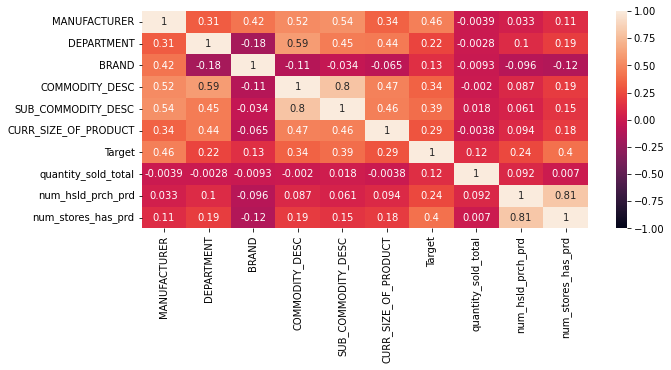

In [46]:
# Lets check for the dependancy of the predictors on target variable.
plt.figure(figsize=(10,4))
sns.heatmap(df1.corr(),annot=True,vmin=-1,vmax=+1)
plt.show()

In [47]:
df1.dtypes

MANUFACTURER            float64
DEPARTMENT              float64
BRAND                   float64
COMMODITY_DESC          float64
SUB_COMMODITY_DESC      float64
CURR_SIZE_OF_PRODUCT    float64
Target                  float64
quantity_sold_total     float64
num_hsld_prch_prd       float64
num_stores_has_prd      float64
dtype: object

In [48]:
# checking for correlation with the tgt..
train_df1=df1[df1.Target.notna()]
test_df1=df1[df1.Target.isnull()]

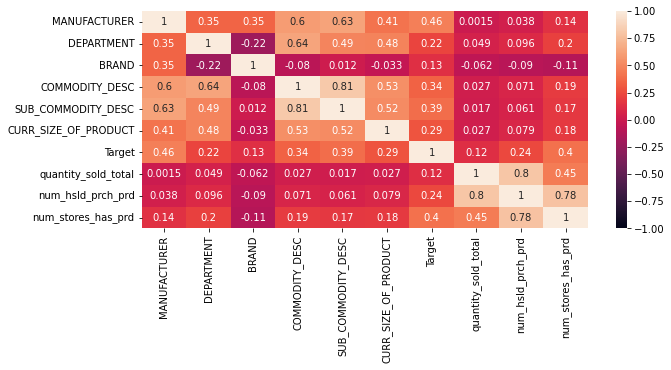

In [49]:
# correlation plot..
plt.figure(figsize=(10,4))
sns.heatmap(train_df1.corr(),annot=True,vmin=-1,vmax=+1)
plt.show()

In [50]:
# splitting into train and test..
xtrain_df1=train_df1.drop(columns='Target')
ytrain_df1=train_df1.Target
xtest_df1=test_df1.drop(columns='Target')

In [51]:
xtrain_df1

,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,quantity_sold_total,num_hsld_prch_prd,num_stores_has_prd
PRODUCT_ID,,,,,,,,,
25671,0.000000,0.222738,0.158725,0.043315,0.043315,0.122234,6.0,3.0,3.0
26190,0.030415,0.222738,0.029666,0.129730,0.096398,0.151846,1.0,1.0,1.0
26601,0.030415,0.124915,0.029666,0.098569,0.050030,0.121535,1.0,1.0,1.0
26738,0.030415,0.222738,0.029666,0.172626,0.018293,0.162338,1.0,1.0,1.0
26941,0.030415,0.222738,0.029666,0.172626,0.018293,0.162338,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
18056453,0.116244,0.042952,0.158725,0.078313,0.056264,0.116244,12.0,7.0,7.0
18104791,0.116244,0.002220,0.158725,0.006601,0.093354,0.119894,1.0,1.0,1.0
18105264,0.069856,0.050717,0.158725,0.000031,0.080257,0.059456,13.0,12.0,11.0


In [52]:
# checking for the multicollinearity..
pd.Series([variance_inflation_factor(xtrain_df1.values,i) for i in range(xtrain_df1.shape[1])],index=xtrain_df1.columns).sort_values(ascending=False)
# no multi-collinearity.

COMMODITY_DESC          9.892259
num_hsld_prch_prd       8.379358
SUB_COMMODITY_DESC      8.102530
DEPARTMENT              6.753216
CURR_SIZE_OF_PRODUCT    5.768463
num_stores_has_prd      4.800119
MANUFACTURER            4.079548
BRAND                   3.910891
quantity_sold_total     3.715860
dtype: float64

# Encoding ~ trial 2 => pd.factorize 

In [53]:
df2=d.copy()
for i in catcol:
    df2[i]=pd.factorize(df2[i])[0]

In [54]:
train_df2=df2[df2.Target.notna()]
test_df2=df2[df2.Target.isnull()]

In [55]:
xtrain_df2=train_df2.drop(columns='Target')
ytrain_df2=train_df2.Target
xtest_df2=df2[df2.Target.isnull()]

In [56]:
# checking multicollinearity.
pd.Series([variance_inflation_factor(xtrain_df2.values,i) for i in range(xtrain_df2.shape[1])],index=xtrain_df2.columns).sort_values(ascending=False)
# no multicollinearity is there.

num_hsld_prch_prd       8.147133
num_stores_has_prd      4.157982
COMMODITY_DESC          4.059905
quantity_sold_total     3.695387
SUB_COMMODITY_DESC      3.674937
DEPARTMENT              2.951013
MANUFACTURER            1.779229
CURR_SIZE_OF_PRODUCT    1.157503
BRAND                   1.144365
dtype: float64

# Finalizing the encoding method.

In [57]:
df1.isnull().sum()

MANUFACTURER            25397
DEPARTMENT                417
BRAND                       0
COMMODITY_DESC           5659
SUB_COMMODITY_DESC      25430
CURR_SIZE_OF_PRODUCT     5827
Target                  47972
quantity_sold_total         0
num_hsld_prch_prd           0
num_stores_has_prd          0
dtype: int64

In [58]:
df2.isnull().sum()

MANUFACTURER                0
DEPARTMENT                  0
BRAND                       0
COMMODITY_DESC              0
SUB_COMMODITY_DESC          0
CURR_SIZE_OF_PRODUCT        0
Target                  47972
quantity_sold_total         0
num_hsld_prch_prd           0
num_stores_has_prd          0
dtype: int64

In [59]:
# df1 is rejected as it contains too many null values is the test set
# reason => many newmanufactures, department, commodities were added lattely.
# df2 => is thus selected. => encoding method => pd.factorize.

# Modeling

In [60]:
# spliting the dataset into train and test.
main_train=df2[df2.Target.notna()]
main_test=df2[df2.Target.isnull()]
main_test=main_test.drop(columns='Target')

In [61]:
# checking shape of train after splitting 
main_train.shape

(43933, 10)

In [62]:
# checking shape of test after splitting 
main_test.shape

(47972, 9)

In [63]:
# further spliting
from sklearn.model_selection import train_test_split
X = main_train.drop(columns='Target')
y = main_train.Target

In [64]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,stratify=y)

In [65]:
# importing Models..

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score

knn=KNeighborsClassifier()
nb=GaussianNB()
dt=DecisionTreeClassifier()
rfc=RandomForestClassifier()
ada=AdaBoostClassifier()
gbm=GradientBoostingClassifier()
xgb=XGBClassifier()
cat=CatBoostClassifier()
lgbm=LGBMClassifier()
l=[knn,nb,dt,rfc,ada,gbm,xgb,lgbm]

In [66]:
l

[KNeighborsClassifier(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 AdaBoostClassifier(),
 GradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 LGBMClassifier()]

In [67]:
# modeling X and testing on X iself.
dic_train=pd.DataFrame()
j=0;
l1=['knn','nb','dt','rfc','ada','gbm','xgbm','lgbm']
for i in l:
    m=i.fit(X,y)
    pred=m.predict(X)
    print(i,':')
    print(confusion_matrix(y,pred))
    dic_train.loc[j,'Model']=l1[j]
    dic_train.loc[j,'accuracy_score']=accuracy_score(y,pred)
    dic_train.loc[j,'f1_score']=f1_score(y,pred)
    dic_train.loc[j,'recall_score']=recall_score(y,pred)
    dic_train.loc[j,'precision_score']=precision_score(y,pred)
    j+=1
    print()

KNeighborsClassifier() :
[[36741  1054]
 [ 2491  3647]]

GaussianNB() :
[[36057  1738]
 [ 3588  2550]]

DecisionTreeClassifier() :
[[37776    19]
 [  300  5838]]

RandomForestClassifier() :
[[37758    37]
 [  283  5855]]

AdaBoostClassifier() :
[[36126  1669]
 [ 2952  3186]]

GradientBoostingClassifier() :
[[36254  1541]
 [ 2738  3400]]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100,

In [68]:
dic_train.sort_values(['accuracy_score','f1_score'],ascending=False)
# here the best performance is given by => RandomForestClassifier(), DecisionTreeClassifier().

,Model,accuracy_score,f1_score,recall_score,precision_score
2,dt,0.992739,0.973406,0.951124,0.996756
3,rfc,0.992716,0.973400,0.953894,0.993720
6,xgbm,0.939749,0.763808,0.697296,0.844348
7,lgbm,0.923861,0.697641,0.628706,0.783553
0,knn,0.919309,0.672940,0.594167,0.775792
5,gbm,0.902602,0.613774,0.553926,0.688120
4,ada,0.894817,0.579642,0.519062,0.656231
1,nb,0.878770,0.489162,0.415445,0.594683


In [69]:
# modeling train and testing on test
dic_test=pd.DataFrame()
j=0;
l1=['knn','nb','dt','rfc','ada','gbm','xgbm','lgbm']
for i in l:
    m=i.fit(xtrain,ytrain)
    pred=m.predict(xtest)
    print(i,':')
    print(confusion_matrix(ytest,pred))
    dic_test.loc[j,'Model']=l1[j]
    dic_test.loc[j,'accuracy_score']=accuracy_score(ytest,pred)
    dic_test.loc[j,'f1_score']=f1_score(ytest,pred)
    dic_test.loc[j,'recall_score']=recall_score(ytest,pred)
    dic_test.loc[j,'precision_score']=precision_score(ytest,pred)
    j+=1
    print()

KNeighborsClassifier() :
[[7186  373]
 [ 684  544]]

GaussianNB() :
[[7231  328]
 [ 733  495]]

DecisionTreeClassifier() :
[[6996  563]
 [ 543  685]]

RandomForestClassifier() :
[[7259  300]
 [ 510  718]]

AdaBoostClassifier() :
[[7216  343]
 [ 578  650]]

GradientBoostingClassifier() :
[[7258  301]
 [ 550  678]]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parall

In [71]:
dic_test.sort_values(['accuracy_score','f1_score'],ascending=False)
# LGBMClassifier(), XGBClassifier() => performs best. 
# => tuning of hyperparameter might improve performance.

,Model,accuracy_score,f1_score,recall_score,precision_score
6,xgbm,0.915329,0.666368,0.605049,0.741517
7,lgbm,0.914078,0.658216,0.592020,0.741081
3,rfc,0.907818,0.639359,0.584691,0.705305
5,gbm,0.903152,0.614409,0.552117,0.692543
4,ada,0.895186,0.585322,0.529316,0.654582
0,knn,0.879709,0.507226,0.442997,0.593239
1,nb,0.879253,0.482691,0.403094,0.601458
2,dt,0.874132,0.553312,0.557818,0.548878
